## SIADS 543 Assignment 4: Improving supervised learning with unsupervised methods.

In this assignment, you'll explore topics from week 4: semi-supervised learning, data imputation and covariate shift, with the underlying theme being how unsupervised learning can improve supervised learning.

*Please note that for autograder messages that check a list, it will typically report any problems using a list index starting at zero, i.e. the first list element is called "element 0".*

In [1]:
# First import some necessary libararies 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(precision = 3)

## Question 1. (35 points total) Semi-supervised learning: label propagation.

We've provided you a dataset where some instances have labels, but most labels are missing. In this question, you'll use label propagation methods from semi-supervised learning to infer the missing labels. The application is classification: the general goal of this question is to answer: was semi-supervised learning using label propagation successful at improving the accuracy of this question's classifier?

The backstory:

A professor and lab assistants spend months manually classifying cancer cells as benign or malignant, and gathering a set of descriptive features based on their visual properties. Their goal is to use support vector machines to predict whether a cancer cell is benign or malignant based on its features.

After painstakingly analyzing and sorting the lab samples into boxes of benign and malignant groups, the clumsy professor accidently spills a mug of artisanal, locally-sourced dark roast Arabica coffee all over the vials, erasing most of their benign/malignant labels. (Each vial and its label represent one data instance.) To add insult to injury, in trying to avoid the coffee the professor knocks the boxes to the floor and the benign/malignant groups get completely mixed together.

Because of the trajectory of the coffee relative to the boxes, the professor estimates these probabilities:

Probability a benign (non-malignant) cell vial (instance) had its label erased: 30%
Probability a malignant cell vial (instance) had its label erased : 90%

Their paper to the journal "Annals of Overfitting and Data Leakage" is due tomorrow. There are two choices they have for training their classifier and they want to maximize accuracy.

`METHOD 1.` Throw away any vials whose labels were erased, and train the classifier ONLY on the much smaller but complete and accurate labeled data that remain.

`METHOD 2.` Attempt to use semi-supervised learning to reconstitute the missing labels, and then train the classifier on that "reconstituted" dataset. An insightful colleague, an instructor for the SIADS 543 course, suggests using a label propagation algorithm in scikit-learn.

Your goal for this question is to train a classifier for each of methods 1 and 2 to see how semi-supervised learning can affect classifier performance.

But before you do that, run the code below to initialize the raw training and test sets. Then, instead of spilling hot coffee, you're going to simulate the label destruction by calling the provided function get_mangled_label_dataset(). 


In [2]:
# Run the following startup code to load the needed (corrupted) dataset and
# its smaller, uncorrupted counterpart.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import load_breast_cancer
(X, y) = load_breast_cancer(return_X_y = True)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, random_state=0)

X_train = StandardScaler().fit_transform(X_train_raw)
X_test  = StandardScaler().fit_transform(X_test_raw)

# This function takes a dataset and label set as input, and returns the following:
#   - The X features of the subset of instances that had intact labels
#   - The y labels of the subset of instances that had intact labels
#   - The X features of the complete training set
#   - The y labels of the complete training set WITH DESTROYED LABELS according to the assignment specifications.
def get_mangled_label_dataset(X_train, y_train):
    rng = np.random.RandomState(0)
    
    frac_0 = 0.30 # as specified in assignment question
    frac_1 = 0.90

    X_train_0 = X_train[y_train == 0]
    y_train_0 = y_train[y_train == 0]

    X_train_1 = X_train[y_train == 1]
    y_train_1 = y_train[y_train == 1]

    X_train_complete = np.vstack((X_train_0, X_train_1))
    y_train_complete = np.concatenate((y_train_0, y_train_1))

    random_unlabeled_points_0 = rng.rand(len(y_train_0)) < frac_0
    random_unlabeled_points_1 = rng.rand(len(y_train_1)) < frac_1
    random_unlabeled_points = np.concatenate((random_unlabeled_points_0, random_unlabeled_points_1))

    random_labeled_points_0 = np.logical_not(random_unlabeled_points_0)
    random_labeled_points_1 = np.logical_not(random_unlabeled_points_1)

    labeled_subset_X_train_0  = X_train_0[random_labeled_points_0]
    labeled_subset_X_train_1  = X_train_1[random_labeled_points_1]
    labeled_subset_y_train_0  = y_train_0[random_labeled_points_0]
    labeled_subset_y_train_1  = y_train_1[random_labeled_points_1]

    labeled_subset_X_train = np.vstack((labeled_subset_X_train_0, labeled_subset_X_train_1))
    labeled_subset_y_train = np.concatenate((labeled_subset_y_train_0, labeled_subset_y_train_1))

    labels_train_with_destroyed = np.copy(y_train_complete)
    labels_train_with_destroyed[random_unlabeled_points] = -1

    return (labeled_subset_X_train, labeled_subset_y_train, X_train_complete, labels_train_with_destroyed)


### Part 1.a (15 points).  Finding the classifier accuracy using Method 1 (train only on the intact remaining labeled data).

In preparation for this part and the next, run get_mangled_dataset(.) on the original training set X_train, and train a `support vector classifier` with default parameters (call this the method 1 classifier) on the resulting subset of the instances that had intact labels. Your function should return a single float: the accuracy of the method 1 classifier on the test set, i.e using X_test, y_test.  No cross-validation required: just a single test run.

In [3]:
from sklearn import svm

# YOUR CODE HERE
labeled_subset_X_train, labeled_subset_y_train, X_train_complete, labels_train_with_destroyed = get_mangled_label_dataset(X_train, y_train)

# YOUR CODE HERE
method1_clf = svm.SVC()
method1_clf.fit(labeled_subset_X_train, labeled_subset_y_train)

def answer_label_propagation_a():
    result = method1_clf.score(X_test, y_test)
    
    return result

In [4]:
answer_label_propagation_a()

0.8811188811188811

In [5]:
stu_ans = answer_label_propagation_a()

assert isinstance(stu_ans, float), "Q1a: Your function should return a float."

del stu_ans

### Part 1.b (20 points).  Finding the classifier accuracy using Method 2 (do label propagation to infer all missing labels and train on the resulting complete training set)

Assuming you've run `get_mangled_dataset(.)` on the original training set X_train, now perform label propagation on the complete training set with missing labels (X_train_complete, y_train_complete_missing).  For label propagations, choose the semi-supervised method in scikit-learn that does label propagation using an affinity matrix based on the normalized graph Laplacian. With that class, **use these settings: the "knn" kernel with n=9 neighbors, alpha = 0.1, max_iter=30, tol=0.001**.

Then, train a linear support vector classifier with default parameters (call this the method 2 classifier) on the resulting complete training set with inferred labels. Your function should return a single float: the accuracy of the method 2 classifier on the test set, i.e using X_test, y_test.  No cross-validation required: just a single test run.

Was the label propagation effective, and save the team's journal submission?

In [6]:
# YOUR CODE HERE
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import accuracy_score

label_spread_model = LabelSpreading(kernel='knn', n_neighbors=9, alpha=0.1, max_iter=30, tol=0.001)
label_spread_model.fit(X_train_complete, labels_train_with_destroyed)

# infer the missing labels.
pred_y_train_complete = label_spread_model.predict(X_train_complete) 

# fit a support vector machine to the complete dataset with inferred labels
svc_label_spread = svm.SVC()
svc_label_spread.fit(X_train_complete, pred_y_train_complete)
test_preds_label_spread = svc_label_spread.predict(X_test)
acc_with_label_spread   = accuracy_score(y_test, test_preds_label_spread)

def answer_label_propagation_b():
    # YOUR CODE HERE
    
    return acc_with_label_spread

In [7]:
acc_with_label_spread

0.951048951048951

In [8]:
stu_ans = answer_label_propagation_b()

assert isinstance(stu_ans, float), "Q1b: Your function should return a float."

del stu_ans

## Question 2 (40 points total)

As discussed in this week's lecture on how unsupervised learning can help supervised learning, `covariate shift` is the name of a phenomenon in which the underlying distribution of the features for the data instances being classified using a trained model is different from the underlying distribution of the data originally used to train the classifier. This is a critical problem since the normal machine learning paradigm of estimating generalization error by minimizing test error on held-out data assumes that any future data instances to be classified are drawn from the same underlying distribution as the data used to train/test the classifier. If this assumption doesn't hold, it means your classifier may be out of date, probably giving worse predictions over time, and in need of retraining. (I use the term "classifier" here but the same applies if you're training/evaluating a regressor.)  Note that covariate shift is different than 'concept drift' which refers to how a *label* definition may change over time.

There are many methods for detecting covariate shift. In this question we will use a simple one based on the methods you've already seen in week 1 for density estimation, and in this week's discussion (in the EM lecture) on Gaussian mixture models (GMM).

Scenario: You have set up an online business selling wine. As part of a site recommender system, you build a regression model that can predict the likely user quality rating for a wine based on several features. These features summarize some of the wine's various quantitative properties (e.g. alcohol % by volume, taste rating, level of sulfites, and other chemical properties) which are provided as part of an analysis by the supplier. Your regression algorithm will try to predict the customers' perceived quality of the wine, which in turn will help you predict possible future demand and also set the wine price accordingly. Your original training data comes from the current set of wines provided by your supplier, plus labels that you gathered (in a time consuming, expensive process) from online customer ratings and in-person tasting.

You won't need detailed knowledge of the features to use this data, but in case you're curious, each instance of a wine has the following real-valued features:

`"fixed acidity"
"volatile acidity"
"citric acid"
"residual sugar"
"chlorides"
"free sulfur dioxide"
"total sulfur dioxide"
"density"
"pH"
"sulphates"
"alcohol"`

In addition, there's a final column which is the instance label, i.e. the quality rating:
   `"quality"`  (This is an ordinal quality rating from 1-10 from a human judge: higher is better quality.)

Before starting, run the preamble code below to load the various dataset(s) you'll need.

**NOTE: As always, use random_state = 42 for any regressor, mixture model, or other scikit-learn call that takes it as an argument.**

In [9]:
from sklearn.preprocessing import StandardScaler

# Load your base training set that will be used to train the starting classifier.
df_base = pd.read_csv("assets/wine-base-dataset.csv")
X_base = df_base.iloc[:, :-1]  # take all columns except the last
y_base = df_base.iloc[:, -1]  # take just the last column (the quality score, which is the regression target)

X_base_normalized   = StandardScaler().fit_transform(X_base)

### Part 2.a (10 points). Compute the baseline regression score of your wine quality classifier using the existing base dataset.

You decide to start by using a random forest regressor for your quality predictions. Using your existing complete X_base_normalized dataset, compute the mean five-fold cross-validation score achieved by a default random forest regressor.  Your function should return a `float` representing this mean score.

In [10]:
# YOUR CODE HERE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

regressor = RandomForestRegressor(random_state=42)
val_score = cross_val_score(regressor, X_base_normalized, y_base)
val_score_mean = val_score.mean()

def answer_covariate_shift_a():
    
    return val_score_mean

In [11]:
answer_covariate_shift_a()

0.3081286839917401

In [12]:
stu_ans = answer_covariate_shift_a()

assert isinstance(stu_ans, float), "Q2a: Your function should return a float."

del stu_ans

### Part 2.b (10 points) Fit a Gaussian mixture model to the base dataset. Evaluate the average log probability density of the base dataset under this GMM. 

Create an instance of the sklearn.mixture class GaussianMixture with 5 components and a full covariance matrix, and fit it using the base dataset.

You can refer to the week 1 notebook density estimation examples for the method you use to fit a mixture model, and to compute the log probability density of a set X of instances.

Your function should return a `float` containing the mean log probability of the base dataset instances under this GMM.

In [13]:
# YOUR CODE HERE
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=5, covariance_type='full', random_state=42).fit(X_base_normalized)
mean_log_density_estimate = gm.score_samples(X_base_normalized).mean() #score_samples returns log

def answer_covariate_shift_b():
    
    return mean_log_density_estimate
answer_covariate_shift_b()

-9.96941828092567

In [14]:
stu_ans = answer_covariate_shift_b()

assert isinstance(stu_ans, float), "Q2b: Your function should return a float."

del stu_ans

### Part 2.c (5 points) Given a dataset of new items without labels, compute the average log probability of the new item dataset under this GMM.

A new wine inventory list comes in from your supplier in the file `wine-newitems-dataset.csv`.  These are the wines the supplier expects to be able to deliver in the next month and they come with the usual features.

You decide to check for covariate shift by seeing how likely, on average, these new items are in the GMM trained with the (old) base dataset. If the new items are really unlikely, it may be time to consider making the effort to get labels for some or all of these new items in order to create an updated training set. (Okay - if you look closely the newitems dataset already has a final quality label column you will use for Part 2d, but for the purposes of this question, you can ignore that column.)

Your function should return a float with the mean log probability of the new item samples under the base GMM you fit in Part 2b (trained with the base dataset).

Compare this to your answer from Part 2b, the mean log probability of the (old) base samples under the same GMM. 
What is the difference? (Note that log probabilities will be negative numbers, since probabilities are between 0 and 1.)

Run the code below to load and normalized a dataset of new items (that are unlabeled).

In [15]:
# Use this code to load the new items dataset

df_newitems = pd.read_csv("assets/wine-newitems-dataset.csv")
X_newitems = df_newitems.iloc[:, :-1]    # ignore the label for now

X_newitems_normalized = StandardScaler().fit_transform(X_newitems)

In [16]:
# YOUR CODE HERE
new_mean_log_density_estimate = gm.score_samples(X_newitems_normalized).mean() #score_samples returns log

def answer_covariate_shift_c():

    return new_mean_log_density_estimate

answer_covariate_shift_c()

-17.452028836339213

In [17]:
stu_ans = answer_covariate_shift_c()

assert isinstance(stu_ans, float), "Q2c: Your function should return a float."

del stu_ans

### Part 2.d (15 points) Test the original classifier on the new labeled items, and retrain your original classifier by incorporating the new labeled training data.

Based on the results of the previous analysis, you decide to retrain your random forest regressor. (You pay a survey firm to get judges who provide the quality scores.)

First create a new combined dataset by appending the `newitems` labeled dataset *after* the end of the `base` labeled dataset.

Now that you have the new item labels you should compute two numbers here:

(i) The score you get when using X_newitems_normalized and y_newitems as the test set with a RandomForest regressor trained on the original base dataset only (no cross-validation, just one run).  This is the regression score you would have gotten on the new items if you hadn't retrained the quality prediction model.

(ii) Compute the mean five-fold cross-validation score achieved by a default random forest regressor that uses your updated dataset.

Your function should return a tuple with two `float` elements, containing the results of (i) and (ii), in that order.
Comparing (i) with (ii), was it worth getting the new labeled data?

In [18]:
# Be sure to run this get these labels for the new items!
y_newitems = df_newitems.iloc[:, -1]

In [19]:
#Concatenate normalized base and new datasets
X_complete_normalized = np.vstack((X_base_normalized, X_newitems_normalized))
y_complete = np.vstack((np.array(y_base).reshape(-1, 1), np.array(y_newitems).reshape(-1, 1)))

In [20]:
# YOUR CODE HERE
new_on_old_score = regressor.fit(X_base_normalized, y_base).score(X_newitems_normalized, y_newitems)
updated_score = cross_val_score(regressor, X_complete_normalized, y_complete, cv=5).mean()

def answer_covariate_shift_d():

    return new_on_old_score, updated_score

answer_covariate_shift_d()

(0.04764901800696186, 0.28193821414596937)

In [21]:
stu_ans = answer_covariate_shift_d()

assert isinstance(stu_ans, tuple), "Q2d: Your function should return a tuple."
assert len(stu_ans) == 2, "Q2d: Your tuple should have two floats."
assert isinstance(stu_ans[0], float), "Q2d: Element 0 should be a float."
assert isinstance(stu_ans[1], float), "Q2d: Element 1 should be a float."

del stu_ans

#### Question 2 helper code: You can use this plotting code to compare visually the distributions of the base and newitems datasets to get more intuition about how they might differ.

In [22]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
def plot_labelled_scatterT(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA', "#00FF00", "#FFFFAA", "#0000FF", "#AAAA00", "#00AAAA"]
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)

    plt.show()

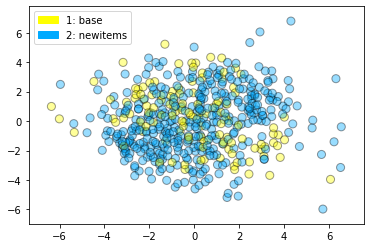

In [23]:
# Question 2: You can use MDS to visualize the base and newitems distributions
# This is one way to quickly check for the possibility of covariate shift.

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS

X_binary = np.vstack((X_base_normalized, X_newitems_normalized))
y_binary = np.concatenate((np.ones(y_base.shape[0]) - 1, np.ones(y_newitems.shape[0])))

# Subsample just a part of the original data for efficiency reasons with MDS
sample = np.random.choice(X_binary.shape[0], 500, replace=False)

dr = MDS(n_components = 2, random_state = 42)
X_low = dr.fit_transform(X_binary[sample])

plot_labelled_scatterT(X_low, y_binary[sample], ['1: base', '2: newitems'])

### Question 3. (25 points) Imputing missing values 

In addition to trying to infer missing *labels* with semi-supervised learning, we can use the Imputer classes of sklearn to fill in missing *values* of the *features*. In this question, you'll use the same dataset as in Question 1, but will look more closely at the process of imputing missing values. Please refer to the week 4 reading, notebook and data imputation lecture for examples of code on how to use an Imputer class (including optionally tied to a Regression class via a pipeline object). 

**Set random_state = 42 for any estimator or other sklearn object that takes it as a parameter.**

In [24]:
# Run this code before proceeding.
# Please note it makes a copy of the original data and does not modify the originals.

CV_SPLITS = 5
rng = np.random.RandomState(0)

### Load the full dataset
from sklearn.datasets import load_breast_cancer
(X_full_raw, y_full) = load_breast_cancer(return_X_y = True)


### Now we create new subset datasets X_full and X_missing with just two features
### for purposes of this question. Random values in X_missing will be marked with NaN,
### (although for those who look closely at the code, you'll see the missingness will
### not necessarily be completely at random, which will become important later!)
X_full = X_full_raw[:, (14, 25)] 

# We create a train/test split although this is for internal statistical reasons 
# and the split will not be used in the questions themselves.
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, random_state = 0)

mu = X_train.mean(axis = 0)
MU_WIDTH = 2

n_samples = X_train.shape[0]
X_train_missing = X_train.copy()
u = rng.uniform(low=mu[0], high=mu[0]*MU_WIDTH, size=(n_samples,))
X_train_missing[np.where(u < X_train[:,0])[0], 0] = np.nan
u = rng.uniform(low=mu[1], high=mu[1]*MU_WIDTH, size=(n_samples,))
X_train_missing[np.where(u < X_train[:,1])[0], 1] = np.nan

n_samples = X_test.shape[0]
mu = X_test.mean(axis = 0)
X_test_missing = X_test.copy()
u = rng.uniform(low=mu[0], high=mu[0]*MU_WIDTH, size=(n_samples,))
X_test_missing [np.where(u < X_test[:, 0])[0], 0] = np.nan
u = rng.uniform(low=mu[1], high=mu[1]*MU_WIDTH, size=(n_samples,))
X_test_missing [np.where(u < X_test[:, 1])[0], 1] = np.nan

## The final "missing data" version of the full dataset:
X_missing = np.vstack((X_train_missing, X_test_missing))
y_missing = np.append(y_train, y_test)

# For the next questions:
# - use X_full for "the full dataset" 
# - use X_missing & y_missing for the missing values dataset: this contains random np.nan values

### Part 3.a (5 points) Establish a full data prediction baseline.
With the full dataset X_full, y_full, and using LogisticRegression with default parameters, write a function to compute the mean five-fold cross-validation classifier score on the full dataset. Return that result as a single float.

In [25]:
# YOUR CODE HERE
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42)
score_3a = cross_val_score(clf, X_full, y_full, cv=5).mean()

def answer_imputation_a():
    # YOUR CODE HERE
    return score_3a
answer_imputation_a()

0.7890855457227139

In [26]:
stu_ans = answer_imputation_a()

assert isinstance(stu_ans, float), "Q3a: Your function should return a float."

del stu_ans

### Part 3.b. (10 points) Use simple imputation, with and without adding indicator variables.

Not only will a scikit-learn Imputer object fill in the missing values of the input dataset, but setting the Imputer option `add_indicator=True` will cause extra binary indicator features to be added to the imputed dataset: a set of binary variables, one per original feature, for remembering which features *in that row* were imputed. Why would this be useful?  It's useful because if the values are *not* missing completely at random and e.g. are related to the range of a variable -- for example, if people with higher incomes are less likely to reveal them in a survey -- then by adding these extra binary features, the classifier has at least a chance for learning something about the relationship of how the 'missingness' might relate to the target value. In other words, the very fact that a value is missing can tell the classifier at least something potentially about its range or distribution, which might be useful for learning. 

In case you're curious, we have designed a "missing not completely at random" (i.e conditionally random) dataset below based on the mean value in each column: the likelihood of a missing value increases with the variable magnitude. 

The purpose of this question is to see what the effect is on classifier accuracy in such a scenario from setting add_indicator = True to add those extra binary indicator features. (It's instructive to take a look at the output of the Imputer object on your own to see how the indicator variables are added in response to missing values.)

Write a function that:

(i)  Uses a SimpleImputer with parameters `missing_values = np.nan`, mean imputation strategy, and `add_indicator = False`, using a pipeline to connect the SimpleImputer to a LogisticRegression classifier with default parameters. With this composite pipeline estimator, compute the mean five-fold cross-validation classifier score on the X_missing dataset.

(ii) Runs exactly the same steps as above, but with the SimpleImputer's parameter `add_indicator = True`.

Your function should return a tuple of two floats: the results of (i) and (ii) in that order.

In [27]:
# YOUR CODE HERE
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

imputer1 = SimpleImputer(missing_values=np.nan, add_indicator=False, strategy='mean')
imputer2 = SimpleImputer(missing_values=np.nan, add_indicator=True, strategy='mean')
estimator1 = make_pipeline(imputer1, clf)
estimator2 = make_pipeline(imputer2, clf)
impute_scores1 = cross_val_score(estimator1, X_missing, y_missing, cv=5).mean()
impute_scores2 = cross_val_score(estimator2, X_missing, y_missing, cv=5).mean()

def answer_imputation_b():

    return impute_scores1, impute_scores2

answer_imputation_b()

(0.6765719608756404, 0.7627387051700046)

In [28]:
stu_ans = answer_imputation_b()

assert isinstance(stu_ans, tuple), "Q3b: Your function should return a tuple."
assert len(stu_ans) == 2, "Q3b: Your tuple should have two floats."
assert isinstance(stu_ans[0], float), "Q3b: Element 0 should be a float."
assert isinstance(stu_ans[1], float), "Q3b: Element 1 should be a float."

del stu_ans

### Part 3.c (10 points) Run iterative imputation with indicator variables.

Write a function that uses code very similar to the one you created in the previous step, but modified to use an IterativeImputer class, with the estimator property set to `DecisionTreeRegressor(random_state = 42)' so that it will use regression trees to perform the imputation. This custom estimator property is one example of the IterativeImputer's flexibility. Set add_indicator = True to add the extra imputation indicator features for the LogisticRegression classifier (default settings). Compute the mean five-fold cross-validation classifier score on the X_missing dataset and return that from your function.

In [29]:
# YOUR CODE HERE
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

imputer3 = IterativeImputer(random_state=42, 
                            estimator=DecisionTreeRegressor(random_state=42), 
                            add_indicator=True)
estimator3 = make_pipeline(imputer3, clf)
impute_scores3 = cross_val_score(estimator3, X_missing, y_missing, cv=5).mean()

def answer_imputation_c():

    return impute_scores3

answer_imputation_c()

0.7609843192050924

In [30]:
stu_ans = answer_imputation_c()

assert isinstance(stu_ans, float), "Q3c: Your function should return a float."

del stu_ans